# Performs the basic analyses of the extracted models 
* model sizes
* Jaccard index calculation
* reaction specificity analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import scipy.stats as stats

import statsmodels.stats.multitest as multi

In [2]:
plt.rcParams.update({'font.size': 18})

Set the folder in which data are stored.

In [3]:
folder = "model_csv"

# Additional settings
Set the data you want to analyse and the labels to display with a dataset.

In [4]:
MEM_labels = {"INIT":"INIT", "TINIT":"tINIT", "GIMME":"GIMME", "IMAT":"iMAT"}
dataset_labels = {'NHBE':'HBE', 'LUNG':'Lung', '293T':'293T', 'CALU':'Calu-3', 'A549':'A549'}

order = {'MEM': ['iMAT', 'GIMME', 'INIT', 'tINIT'],
         'infection': ['healthy', 'infected'],
         'dataset': ['HBE', 'Lung', '293T', 'Calu-3', 'A549']}

In [5]:
box = 1 # boxplots (1) or violinplots (0)

# Metadata import
Read the data from the designated folder

In [6]:
models = [os.path.splitext(name)[0] for name in os.listdir(folder) if name.endswith('csv')]

In [7]:
len(models)

40

In [8]:
MEMs = list(set([model.split("_")[0] for model in models]))
infections = list(set([model.split("_")[2] for model in models]))
datasets = list(set([model.split("_")[3] for model in models]))

In [9]:
MEMs

['INIT', 'Gimme', 'tINIT', 'IMAT', 'iMAT']

In [10]:
datasets

['NHBE', 'Lung', '293T', 'A549', 'CALU']

In [11]:
infections

['H', 'I']

In [12]:
MEMs = {}
infections = {}
datasets = {}

model_MEMs = {}
model_infections = {}
model_datasets = {}

for model in models:
    MEM = model.split("_")[0]
    MEM = MEM_labels[MEM.upper()]
                   
    infection = model.split("_")[2]
    infection = 'healthy' if infection == 'H' else 'infected'
    
    dataset = model.split("_")[3] 
    dataset = dataset_labels[dataset.upper()]  
    
 
    if MEM not in MEMs:
        MEMs[MEM] = []
    if infection not in infections:
        infections[infection] = []
    if dataset not in datasets:
        datasets[dataset] = []

    MEMs[MEM].append(model)
    infections[infection].append(model)
    datasets[dataset].append(model)  
    
    model_MEMs[model] = MEM
    model_infections[model] = infection
    model_datasets[model] = dataset
    

In [13]:
groups = {"MEM": MEMs, "infection": infections, "dataset": datasets}

# Model import

In [14]:
file_names = [file_name for file_name in os.listdir(folder) if file_name.endswith('csv')]

In [15]:
model_reactions = {}
for file_name in file_names:
    model_name = os.path.splitext(file_name)[0]    
    
    df2 = pd.read_csv(os.path.join(folder,file_name), sep=",")
    condition = (df2['lower_flux_bound'] < df2['upper_flux_bound'])# | ((df2['upper_flux_bound'] != 0) & (df2['lower_flux_bound'] != 0))
    active_reactions = set(df2.loc[condition, 'reaction_ID'].values)
    
    model_reactions[model_name] = active_reactions   

# Model sizes
Assess the model sizes

In [16]:
df_sizes = pd.DataFrame(columns = ["model", "MEM", "infection", "dataset", "size"], dtype=float)

for model_name, active_reactions in model_reactions.items():
    model = model_name      
    size = len(active_reactions)
    MEM = model_MEMs[model]
    infection = model_infections[model]
    dataset = model_datasets[model]
    
    d = {'model': model, 'size':size, 'MEM': MEM, 'infection': infection, 'dataset': dataset}
    df_sizes = df_sizes.append(d, ignore_index=True, sort=False)

In [17]:
df_sizes.to_csv('results_basic\\model_sizes.csv', index=False)

In [18]:
df_sizes.describe()

,size
count,40.000000
mean,4236.500000
std,1728.204315
min,2600.000000
25%,3022.750000
50%,3370.500000
75%,4848.500000
max,7233.000000


Plot the model sizes

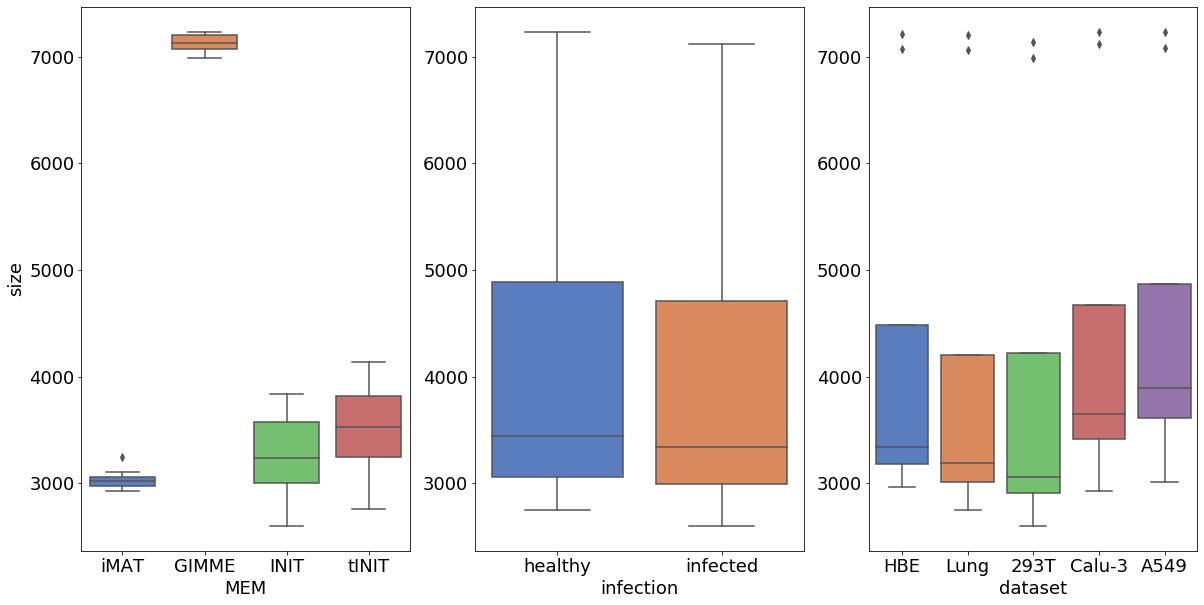

In [19]:
data = df_sizes

fig, axes = plt.subplots(1,len(groups))

for i,factor in enumerate(groups):
    
    
    ax = axes.flat[i]
    
    if box:
        sns.boxplot(x=factor, y='size', data=data, palette="muted", showfliers = True, ax=ax, order=order[factor])
    else:    
        sns.violinplot(x=factor, y='size', data=data, palette="muted", ax=ax, cut=0, order=order[factor])
        
    if i == 0:
        ax.set_ylabel("size")
    else:
        ax.set_ylabel("")
    
fig.set_size_inches([20,10])
plt.savefig(os.path.join('results_basic\\model_sizes.pdf'), bbox_inches = 'tight')
    
plt.show()
    

## Statistics
Save the basic statistics to a file

In [20]:
f = open("results_basic\\model_statistics.txt", "w")

for factor in groups:
    print("*****", file=f)
    print(factor, file=f)
    print("***", file=f)
    for group in groups[factor]:
        print(group, file=f)
        print(df_sizes[df_sizes[factor] == group].describe(), file=f)
        print("***", file=f)
        
f.close()

## p-values
Calculate the significances of model size differences between the groups

In [21]:
res = {}

for factor in groups:
    s = []
    for value in groups[factor]:
        sizes = df_sizes.loc[df_sizes[factor]==value, 'size']
        s.append(list(sizes))
    
    if len(s) == 2:
        p = stats.ks_2samp(*s)[1] # KS
        #p = stats.mannwhitneyu(*s)[1] # MW
        #p = stats.ttest_ind(*s)[1] # unpaired t-test
    else:
        p = stats.kruskal(*s)[1]
        
    res[factor] = p

res   

{'MEM': 8.51118294696118e-06,
 'infection': 0.49734233531361083,
 'dataset': 0.30844104118400123}

# Jaccard index
Calculate Jaccard indices within vs. between a factor.

Example:
* within: combinations between the models for GIMME
* between: combinations of a GIMME model with all other models

In [22]:
def jaccard(s1, s2):
    return len(s1&s2)/len(s1|s2)

In [23]:
df_jaccard = pd.DataFrame(columns=['pair', 'MEM1', 'MEM2', 'infection1', 'infection2', 'dataset1', 'dataset2', 'Jaccard'])
# factor: MEM, dataset, infection
# group: factor value
# type: 'within' or 'between'
# Jaccard: Jaccard index

for model1 in models:
    for model2 in models:
        if model1 < model2:
            pair = model1, model2
        elif model1 > model2:
            pair = model2, model1
        else:
            continue
    
        if pair in df_jaccard['pair']:
            continue
        d = {'pair': pair}
        d['MEM1'] = model_MEMs[model1]
        d['MEM2'] = model_MEMs[model2]
        d['infection1'] = model_infections[model1]
        d['infection2'] = model_infections[model2]
        d['dataset1'] = model_datasets[model1]
        d['dataset2'] = model_datasets[model2]
        d['Jaccard'] = jaccard(model_reactions[model1], model_reactions[model2])
        
        df_jaccard = df_jaccard.append(d, ignore_index=True, sort=False)

In [24]:
df_jaccard.to_csv('results_basic\\jaccard.csv', index=False)

## Within the groups

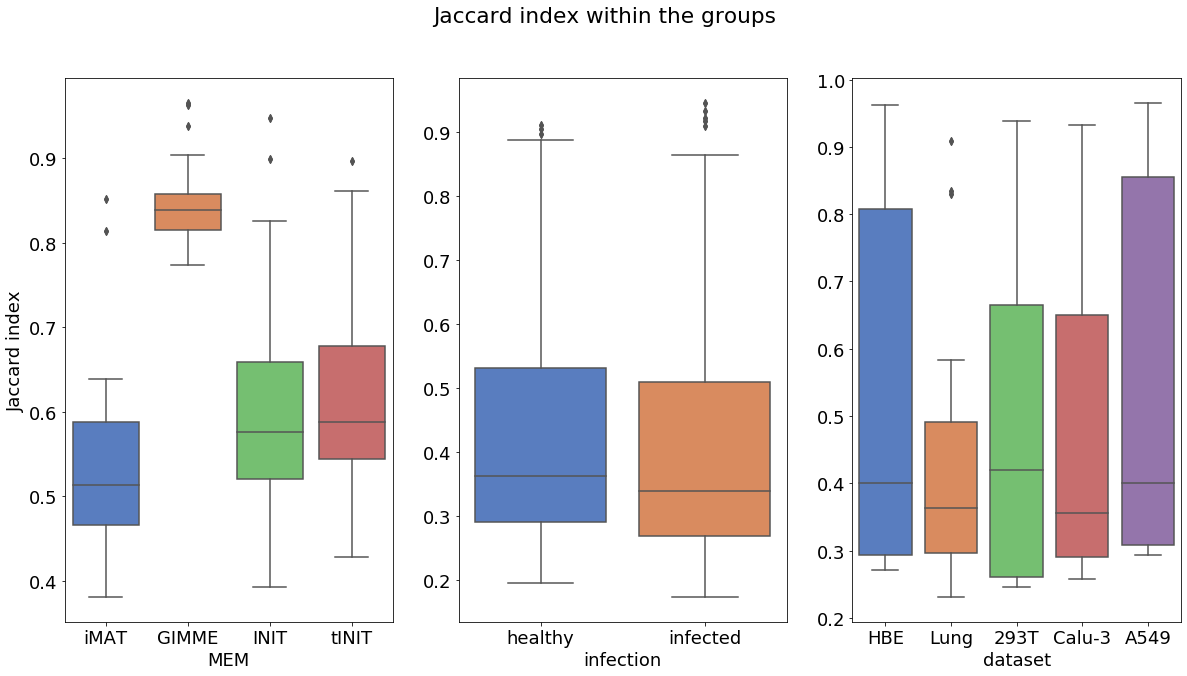

In [25]:
fig, axes = plt.subplots(1,len(groups))

for i,factor in enumerate(groups):  
    ax = axes.flat[i]
        
    condition = df_jaccard[f'{factor}1'] == df_jaccard[f'{factor}2']
    data = df_jaccard[condition]
    
    if box:
        sns.boxplot(x=f'{factor}1', y='Jaccard', data=data, palette="muted", showfliers = True, ax=ax, order=order[factor])
    else:    
        sns.violinplot(x=f'{factor}1', y='Jaccard', data=data, palette="muted", ax=ax, cut=0, order=order[factor])
    
    ax.set_xlabel(factor)
    
    if i == 0:
        ax.set_ylabel("Jaccard index")
    else:
        ax.set_ylabel("")
    
plt.suptitle("Jaccard index within the groups")       
fig.set_size_inches([20,10])
plt.savefig(os.path.join('results_basic\\jaccard_within.pdf'), bbox_inches = 'tight')
    
plt.show()    

## Between the groups

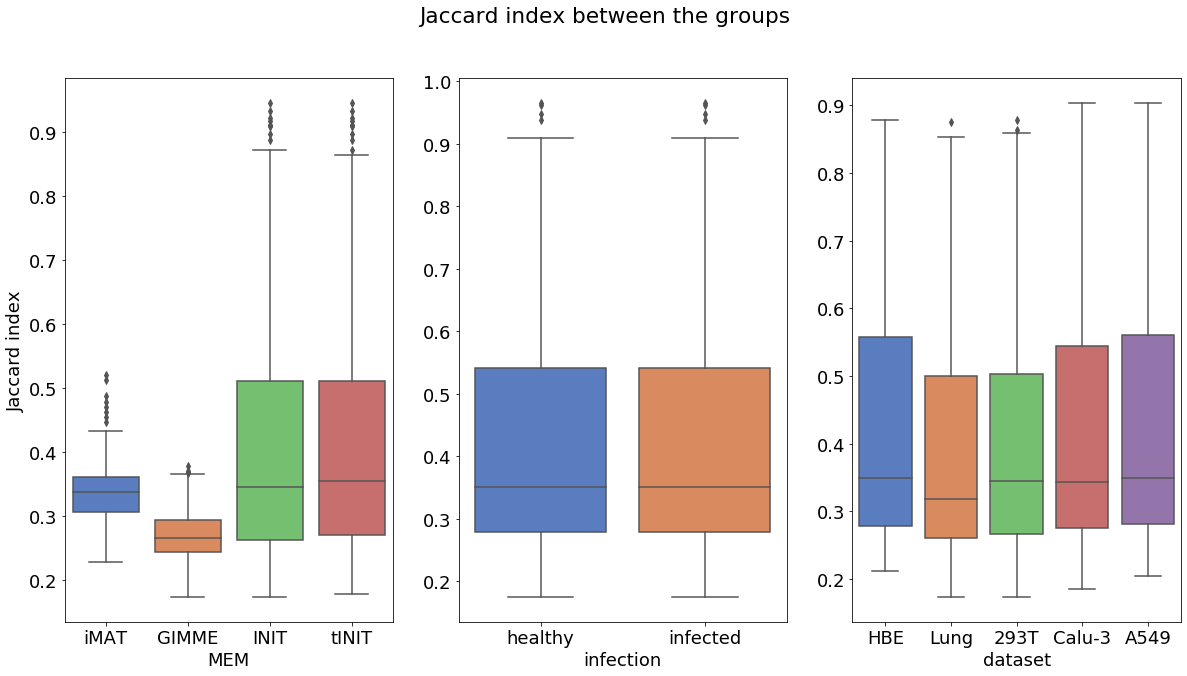

In [26]:
fig, axes = plt.subplots(1,len(groups))

for i,factor in enumerate(groups):  
    ax = axes.flat[i]
        
    condition = df_jaccard[f'{factor}1'] != df_jaccard[f'{factor}2']
    data = df_jaccard[condition]
    
    if box:
        sns.boxplot(x=f'{factor}1', y='Jaccard', data=data, palette="muted", showfliers = True, ax=ax, order=order[factor])
    else:    
        sns.violinplot(x=f'{factor}1', y='Jaccard', data=data, palette="muted", ax=ax, cut=0, order=order[factor])
    
    ax.set_xlabel(factor)
    
    if i == 0:
        ax.set_ylabel("Jaccard index")
    else:
        ax.set_ylabel("")
    
plt.suptitle("Jaccard index between the groups")       
fig.set_size_inches([20,10])
plt.savefig(os.path.join('results_basic\\jaccard_between.pdf'), bbox_inches = 'tight')
    
plt.show()    
    

### Two-sample Kolmogorov–Smirnov test of Jaccard index within and between the groups

In [27]:
df_between = pd.DataFrame(columns=['factor', 'group', 'p', 'q'])

for factor in groups:  
    ax = axes.flat[i]
        
    condition1 = df_jaccard[f'{factor}1'] == df_jaccard[f'{factor}2']
    within = df_jaccard[condition1]
    
    condition2 = df_jaccard[f'{factor}1'] != df_jaccard[f'{factor}2']
    between = df_jaccard[condition]
    
    d = {'factor': factor}
    
    
    for group in groups[factor]:
        d['group'] = group        
        x = within[within[f'{factor}1'] == f'{group}'].Jaccard.values
        y = between[between[f'{factor}1'] == f'{group}'].Jaccard.values        
        p = stats.ks_2samp(x,y)[1] # KS
        d['p'] = p
        df_between = df_between.append(d, ignore_index=True, sort=False)
        
df_between['q'] = multi.multipletests(df_between["p"], method = 'fdr_bh')[1]

In [28]:
f = open("results_basic\\jaccard.txt", "w")
print(df_between.round(5).to_latex(index=False), file=f)
f.close()